In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, preprocessing
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, confusion_matrix
from sklearn.model_selection import KFold
from prettytable import PrettyTable

In [2]:
PATH_ROOT = os.path.join(Path().absolute().parent)
print(PATH_ROOT)

/home/lukec/workspace/label_flip_revised


In [3]:
df_cm = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth_cmeasures_nn.csv'))
df_cm = df_cm.sort_values(by=['Data', 'Rate'], ignore_index=True)
df_cm.head()

,Data,F1,F1 SD,F1v,F2,F3,F4,N1,N2,N2 SD,...,C2,Density,ClsCoef,Hubs,HubsSD,Rate,Filepath,Testpath,Train,Test
0,f04_i02_r00_c01_w6_1,0.810730,0.372452,0.054200,0.334868,0.504,0.4245,0.030,0.200008,0.109163,...,0.077664,0.848518,0.406686,0.766283,0.302880,0.00,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_clean_...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.985,0.994
1,f04_i02_r00_c01_w6_1,0.871642,0.236221,0.157394,0.478438,0.762,0.6860,0.082,0.262551,0.115698,...,0.020594,0.862773,0.400181,0.770124,0.299065,0.05,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.934,0.994
2,f04_i02_r00_c01_w6_1,0.898315,0.188025,0.250773,0.565290,0.690,0.6360,0.126,0.264643,0.140696,...,0.278243,0.865011,0.415929,0.642544,0.312808,0.10,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.889,0.932
3,f04_i02_r00_c01_w6_1,0.924654,0.092116,0.302377,0.436307,0.690,0.6140,0.115,0.279178,0.123644,...,0.019025,0.870060,0.382698,0.761814,0.292958,0.15,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.881,0.895
4,f04_i02_r00_c01_w6_1,0.932818,0.088960,0.343645,0.512272,0.631,0.5850,0.107,0.261546,0.134748,...,0.532007,0.863499,0.437701,0.639688,0.248479,0.20,data/synth/alfa_nn/f04_i02_r00_c01_w6_1_nn_ALF...,data/synth/test/f04_i02_r00_c01_w6_1_clean_tes...,0.831,0.694


In [4]:
print(df_cm.shape)
print(df_cm.columns)

(2697, 34)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'HubsSD',
       'Rate', 'Filepath', 'Testpath', 'Train', 'Test'],
      dtype='object')


In [5]:
# Split datasets into 3 difficulties
DIF_LEVELS = ['Hard', 'Normal', 'Easy']
N_BINS = len(DIF_LEVELS)
difficulty_mapping = {0: DIF_LEVELS[0], 1: DIF_LEVELS[1], 2: DIF_LEVELS[2]}

encoder = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='uniform')
acc_test_clean = df_cm[df_cm['Rate'] == 0]['Test'].to_numpy()
ordinal_clean = encoder.fit_transform(acc_test_clean.reshape([-1, 1])).flatten().astype(int)

print('Convert test set accuracy into ordinal data:')
for i in range(N_BINS):
    start = encoder.bin_edges_[0][i]
    end = encoder.bin_edges_[0][i+1]
    print('{} in [{:.3f}, {:.3f})'.format(DIF_LEVELS[i], start, end))

Convert test set accuracy into ordinal data:
Hard in [0.490, 0.658)
Normal in [0.658, 0.826)
Easy in [0.826, 0.994)


In [6]:
POISON_LVLS = np.round(np.arange(0, 0.41, 0.05, dtype=float), 2)
POISON_LVLS

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ])

In [7]:
datanames = df_cm[df_cm['Rate'] == 0]['Data'].to_numpy()
df_cm['Difficulty'] = 0
for data, dif in zip(datanames, ordinal_clean):
    idx = df_cm[df_cm['Data'] == data].index
    df_cm.loc[idx, ['Difficulty']] = dif

df_cm['Difficulty'] = df_cm['Difficulty'].replace(difficulty_mapping)

In [8]:
col_X = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3 ', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'HubsSD'
]
col_y = 'Test'

In [9]:
alpha = 0.03
N_FOLD = 5

df_cm['prediction'] = 0

# Split by clean data
indices_clean = df_cm[df_cm['Rate'] == 0].index
kf = KFold(n_splits=N_FOLD, shuffle=True)
for i_train, i_test in kf.split(indices_clean):
    idx_train_clean = indices_clean[i_train]
    idx_test_clean = indices_clean[i_test]

    data_train = df_cm.loc[idx_train_clean, 'Data']
    data_test = df_cm.loc[idx_test_clean, 'Data']

    idx_train = df_cm[df_cm['Data'].isin(data_train)].index
    idx_test = df_cm[df_cm['Data'].isin(data_test)].index
    assert len(idx_train) + len(idx_test) == df_cm.shape[0]

    X_train = df_cm.loc[idx_train, col_X]
    y_train = df_cm.loc[idx_train, col_y]
    X_test = df_cm.loc[idx_test, col_X]
    y_test = df_cm.loc[idx_test, col_y]

    regressor = linear_model.Ridge(alpha=alpha)
    regressor.fit(X_train, y_train)

    df_cm.loc[idx_test, 'prediction'] = regressor.predict(X_test)

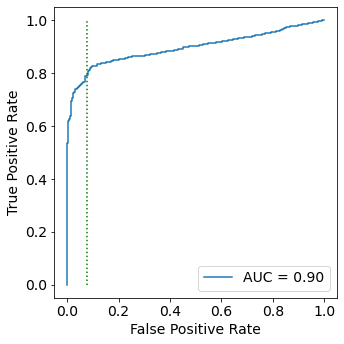

In [10]:
THRESHOLD = 0.00

FONTSIZE = 14
FIGSIZE = (5, 5)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
y_true_ = (df_cm['Rate'] > THRESHOLD).astype(int)
y_score_ = np.abs(df_cm['prediction'] - df_cm['Train'])
fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
roc_auc_ = auc(fpr, tpr)
idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
threshold = thresholds[idx_t]
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_).plot(ax=ax)
ax.vlines(threshold, 0, 1, linestyles='dotted', label='threshold', colors='green')
plt.tight_layout()
plt.show()

In [11]:
print('C-Measure threshold:', threshold)

C-Measure threshold: 0.0784852466630439


In [12]:
results = np.abs(df_cm['prediction'] - df_cm['Train']) > threshold

In [13]:
y_true = (df_cm['Rate'] > THRESHOLD).astype(int)
confusion_mat = confusion_matrix(y_true, results)

In [14]:
df_ = df_cm[['Difficulty', 'Rate']].copy()
df_['Label'] = y_true
df_['Prediction'] = results.astype(int)
print(df_.head())

res_ = []
names_row2 = []
for d in DIF_LEVELS:
    for r in POISON_LVLS:
        names_row2.append('{} {}'.format(d, r))
        row = []
        for p in [0, 1]:
            condition = (df_['Difficulty'] == d) & (df_['Rate'] == r) & (df_['Prediction'] == p)
            row.append(df_[condition].shape[0])
        res_.append(row)
res_ = np.array(res_)
res2 = np.zeros((len(res_), 3))
res2[:,0] = res_[:,0]
res2[:,1] = res_[:,1]
res2[:,2] = res_.sum(axis=1)

res2[:,0] = res2[:,0] / res2[:,2]
res2[:,1] = res2[:,1] / res2[:,2]
res2[:,2] = res2[:,2] / res2[:,2]
res2 = np.round(res2, 2)

  Difficulty  Rate  Label  Prediction
0       Easy  0.00      0           0
1       Easy  0.05      1           0
2       Easy  0.10      1           1
3       Easy  0.15      1           0
4       Easy  0.20      1           1


In [15]:
table = PrettyTable()
table.add_column(fieldname='', column=names_row2, align='l')
table.add_column(fieldname='Pred Clean', column=res2[:,0], align='r')
table.add_column(fieldname='Pred Poisoned', column=res2[:,1], align='r')
table.add_column(fieldname='Total', column=res2[:, 2], align='r')
print(table)

+-------------+------------+---------------+-------+
|             | Pred Clean | Pred Poisoned | Total |
+-------------+------------+---------------+-------+
| Hard 0.0    |       0.95 |          0.05 |   1.0 |
| Hard 0.05   |       0.67 |          0.33 |   1.0 |
| Hard 0.1    |        0.5 |           0.5 |   1.0 |
| Hard 0.15   |       0.06 |          0.94 |   1.0 |
| Hard 0.2    |       0.12 |          0.88 |   1.0 |
| Hard 0.25   |        0.0 |           1.0 |   1.0 |
| Hard 0.3    |        0.0 |           1.0 |   1.0 |
| Hard 0.35   |        0.0 |           1.0 |   1.0 |
| Hard 0.4    |        0.0 |           1.0 |   1.0 |
| Normal 0.0  |       0.87 |          0.13 |   1.0 |
| Normal 0.05 |       0.38 |          0.62 |   1.0 |
| Normal 0.1  |        0.8 |           0.2 |   1.0 |
| Normal 0.15 |       0.38 |          0.62 |   1.0 |
| Normal 0.2  |       0.05 |          0.95 |   1.0 |
| Normal 0.25 |       0.01 |          0.99 |   1.0 |
| Normal 0.3  |       0.01 |          0.99 |  

In [16]:
rates = np.tile(POISON_LVLS, reps=len(DIF_LEVELS))
difficulties = np.repeat(DIF_LEVELS, repeats=len(POISON_LVLS))
precision = res2[:,1]
df_confusion_mat = pd.DataFrame({
    'Poisoning Rate': rates,
    'Data Difficulty': difficulties,
    'Precision (PPV)': precision,
})

df_confusion_mat

,Poisoning Rate,Data Difficulty,Precision (PPV)
0,0.00,Hard,0.05
1,0.05,Hard,0.33
2,0.10,Hard,0.50
3,0.15,Hard,0.94
4,0.20,Hard,0.88
5,0.25,Hard,1.00
6,0.30,Hard,1.00
7,0.35,Hard,1.00
8,0.40,Hard,1.00
9,0.00,Normal,0.13


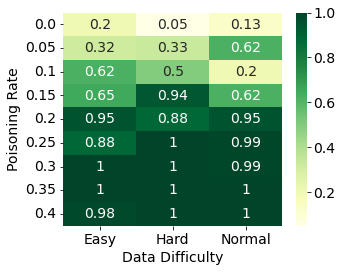

In [17]:
FONTSIZE = 14
FIGSIZE = (5, 4)

plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
cols = df_confusion_mat.columns
confusion_mat_pivot = df_confusion_mat.pivot(cols[0], cols[1], cols[2])
ax = sns.heatmap(confusion_mat_pivot, ax=ax, annot=True, cmap="YlGn")
plt.yticks(rotation=0)
plt.tight_layout()
plot_output = os.path.join(PATH_ROOT, 'results', 'synth_heatmap.pdf')
plt.savefig(plot_output, dpi=300)